# Competition Submission

This notebook details using the classification model and segmentation model trained earlier to predict masks on the test set. This solution scored 139/884 on the private leaderboard.

First, images in the test set are passed through the classification model to determine which images contain ships. Then the ship containing images are passed to the segmentation model to create masks. The predicted masks are cleaned up using some post processing heuristics before being saved to the solution file.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
PATH = Path('F:/ships')

In [4]:
classifier_df = pd.read_csv(PATH/'ships_classification.csv')

In [5]:
classifier_df.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
classifier_df.head()

ImageId  has_ship
0  00003e153.jpg         0
1  0001124c7.jpg         0
2  000155de5.jpg         1
3  000194a2d.jpg         1
4  0001b1832.jpg         0

# Classifier

In [7]:
n = len(classifier_df)
n

192555

In [8]:
val_idxs = get_cv_idxs(n)

In [9]:
f = resnext50
sz = 256

In [10]:
aug_tfms = [RandomRotate(5), 
            RandomLighting(0.05, 0.05), 
            RandomFlip(),
            RandomDihedral()
            ]


tfms = tfms_from_model(f, sz, aug_tfms=aug_tfms, max_zoom=1.01)

In [11]:
f_names = classifier_df.ImageId.values

In [12]:
TRAIN_DN = 'train_v2'

In [13]:
x_names = np.array([Path(TRAIN_DN)/o for o in f_names])

In [14]:
y_vals = classifier_df.has_ship.values

In [15]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [16]:
sz = 768
bs = 128

In [17]:
md = ImageClassifierData.from_names_and_array(PATH, x_names, y_vals, [0, 1],
                                              val_idxs=val_idxs, bs=bs, tfms=tfms, test_name='test_v2')
denorm = md.trn_ds.denorm

In [19]:
learn = ConvLearner.pretrained(f, md, ps=0.4)
learn.opt_fn=optim.Adam

In [20]:
learn.model.cuda();

In [21]:
learn.load('768_all_classifier_rn50_2')

In [22]:
learn.model.cuda();

Predictions are generated using test time augmentation

In [24]:
#Find tta
preds = learn.TTA(is_test=True, n_aug=16)

In [30]:
probs = np.mean(np.exp(preds[0]),0)

In [31]:
probs.shape

(15606, 2)

In [32]:
probs[:,0].shape

(15606,)

While most images are definitively classified, some images proved to be difficult

(array([ 2447.,   176.,   123.,    75.,    86.,    78.,    66.,    99.,   140., 12316.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

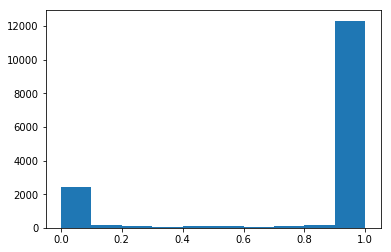

In [33]:
plt.hist(probs[:,0])

In [34]:
classified_df = pd.DataFrame(probs, columns = ['no_ship', 'ship'])

In [35]:
classified_df['fnames'] = md.test_ds.fnames

In [36]:
classified_df.head(20)

no_ship          ship                 fnames
0   9.989206e-01  1.079474e-03  test_v2\00002bd58.jpg
1   9.999706e-01  2.946769e-05  test_v2\00015efb6.jpg
2   9.996214e-01  3.787286e-04  test_v2\00023d5fc.jpg
3   1.162116e-02  9.883788e-01  test_v2\000367c13.jpg
4   9.999461e-01  5.395057e-05  test_v2\0008ca6e9.jpg
5   9.999945e-01  5.595518e-06  test_v2\000a4635f.jpg
6   1.000000e+00  3.570946e-11  test_v2\000bd9dbf.jpg
7   9.997784e-01  2.216384e-04  test_v2\000f7d875.jpg
8   9.118827e-35  1.000000e+00  test_v2\0010551d9.jpg
9   1.000000e+00  1.008889e-10  test_v2\001839c6f.jpg
10  5.346823e-07  9.999995e-01  test_v2\002a943bf.jpg
11  1.000000e+00  1.879743e-10  test_v2\00313b166.jpg
12  9.999678e-01  3.227269e-05  test_v2\00327b02d.jpg
13  5.043555e-04  9.994957e-01  test_v2\0035268d9.jpg
14  9.999622e-01  3.802521e-05  test_v2\003b58a76.jpg
15  1.000000e+00  2.369687e-08  test_v2\0044e3dda.jpg
16  9.999720e-01  2.809374e-05  test_v2\0046967a4.jpg
17  9.998506e-01  1.494766e-04  test_v2\004751507.jpg
18  9.968857e-01  3.114334e-03  test_v2\0047c79fc.jpg
19  9.981286e-01  1.871281e-03  test_v2\004946ceb.jpg

Images with no ships

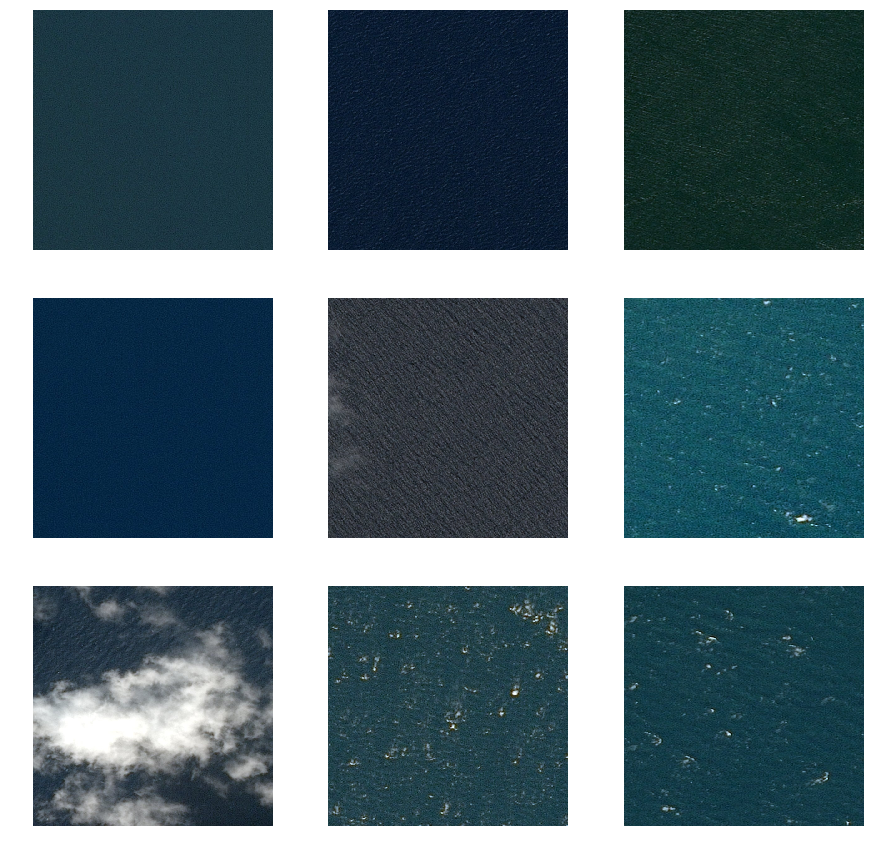

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

no_ship_fnames = classified_df[classified_df.no_ship > 0.9].fnames.values[:9]

for i, (fn, ax) in enumerate(zip(no_ship_fnames, axes.flat)):
    im = open_image(PATH/fn)
    ax = show_img(im, ax=ax)

Images with ships

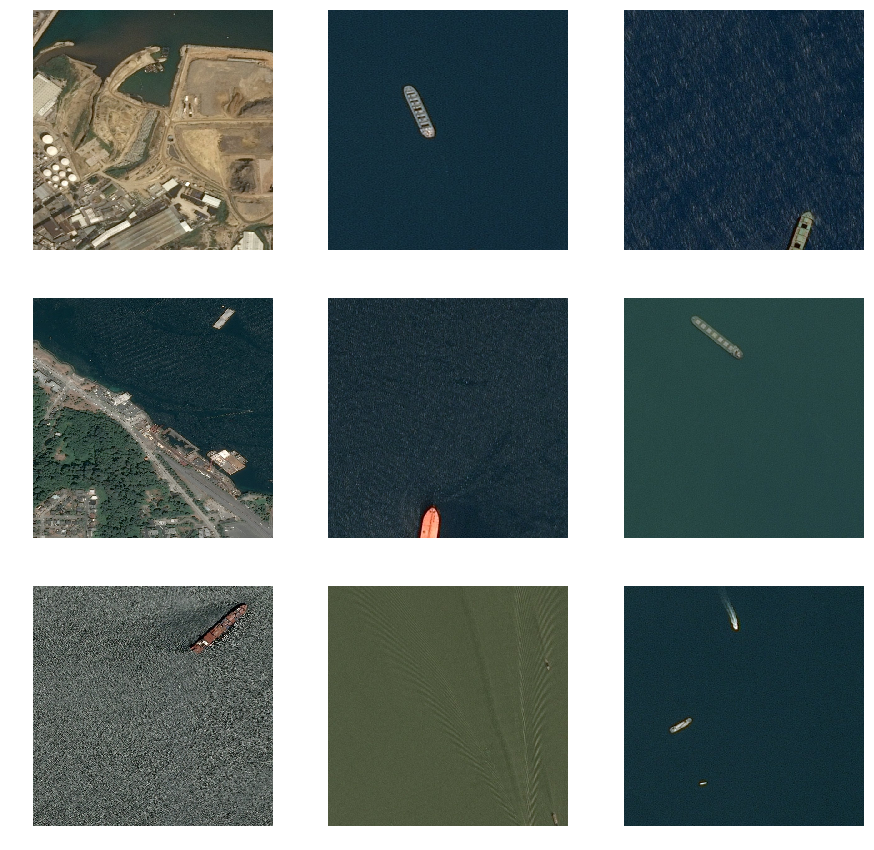

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

ship_fnames = classified_df[classified_df.ship > 0.9].fnames.values[:9]

for i, (fn, ax) in enumerate(zip(ship_fnames, axes.flat)):
    im = open_image(PATH/fn)
    ax = show_img(im, ax=ax)

Difficult to classify images

C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


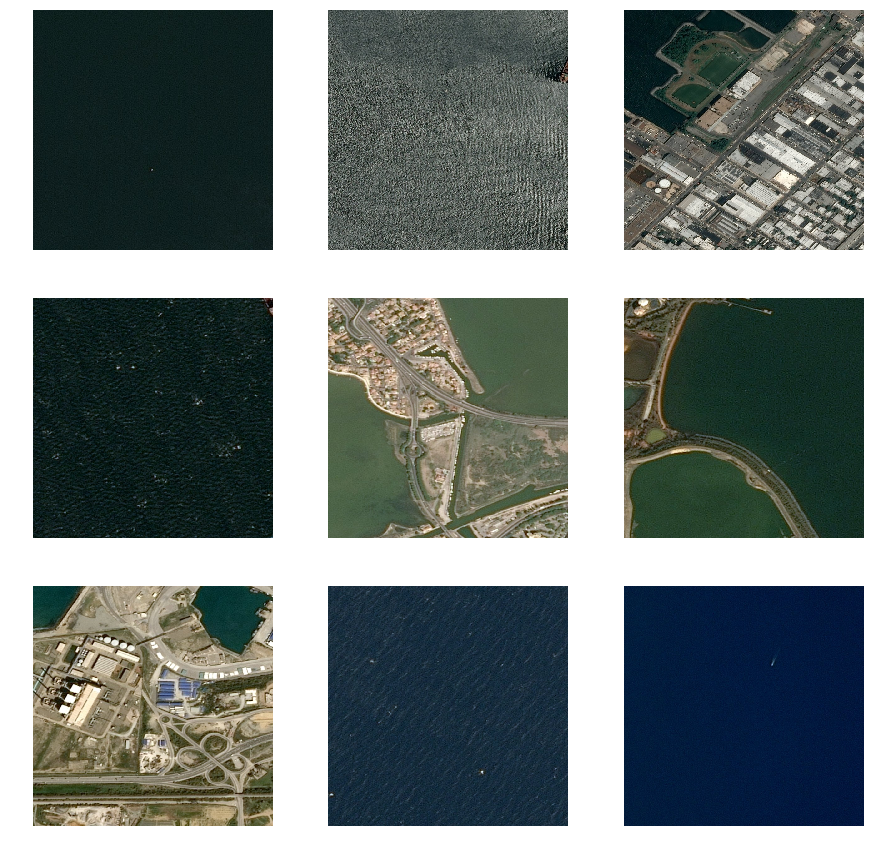

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

ambiguous_fnames = classified_df[classified_df.ship > 0.4][classified_df.ship < 0.6].fnames.values[12:21]

for i, (fn, ax) in enumerate(zip(ambiguous_fnames, axes.flat)):
    im = open_image(PATH/fn)
    ax = show_img(im, ax=ax)


In [40]:
classified_df['Prediction'] = (classified_df.ship > 0.5).astype(int)

In [41]:
classified_df.head(20)

no_ship          ship                 fnames  Prediction
0   9.989206e-01  1.079474e-03  test_v2\00002bd58.jpg           0
1   9.999706e-01  2.946769e-05  test_v2\00015efb6.jpg           0
2   9.996214e-01  3.787286e-04  test_v2\00023d5fc.jpg           0
3   1.162116e-02  9.883788e-01  test_v2\000367c13.jpg           1
4   9.999461e-01  5.395057e-05  test_v2\0008ca6e9.jpg           0
5   9.999945e-01  5.595518e-06  test_v2\000a4635f.jpg           0
6   1.000000e+00  3.570946e-11  test_v2\000bd9dbf.jpg           0
7   9.997784e-01  2.216384e-04  test_v2\000f7d875.jpg           0
8   9.118827e-35  1.000000e+00  test_v2\0010551d9.jpg           1
9   1.000000e+00  1.008889e-10  test_v2\001839c6f.jpg           0
10  5.346823e-07  9.999995e-01  test_v2\002a943bf.jpg           1
11  1.000000e+00  1.879743e-10  test_v2\00313b166.jpg           0
12  9.999678e-01  3.227269e-05  test_v2\00327b02d.jpg           0
13  5.043555e-04  9.994957e-01  test_v2\0035268d9.jpg           1
14  9.999622e-01  3.802521e-05  test_v2\003b58a76.jpg           0
15  1.000000e+00  2.369687e-08  test_v2\0044e3dda.jpg           0
16  9.999720e-01  2.809374e-05  test_v2\0046967a4.jpg           0
17  9.998506e-01  1.494766e-04  test_v2\004751507.jpg           0
18  9.968857e-01  3.114334e-03  test_v2\0047c79fc.jpg           0
19  9.981286e-01  1.871281e-03  test_v2\004946ceb.jpg           0

In [42]:
classified_df.to_csv(PATH/'classified_df_all.csv')

In [18]:
classified_df = pd.read_csv(PATH/'classified_df_all.csv')

# Segmentation

Creating segmentation masks for images with ships

In [19]:
mask_fns = os.listdir(PATH/'masks')

In [20]:
trn_fns = [i.split('_')[0] + '.jpg' for i in mask_fns]

In [21]:
TRAIN_DN = 'train_v2'

In [22]:
MASKS_DN = 'masks'

In [23]:
x_names = np.array([Path(TRAIN_DN)/o for o in trn_fns])
y_names = np.array([Path(MASKS_DN)/o for o in mask_fns])

In [24]:
n = len(x_names)
n

42556

In [25]:
val_idxs = get_cv_idxs(n, val_pct=0.15)

In [26]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [27]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [28]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [29]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [30]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [31]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [32]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [33]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [34]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [35]:
sz = 768
bs = 6

In [36]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [37]:
f = resnet34
cut,lr_cut = model_meta[f]

In [38]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [39]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [40]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [41]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [42]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [43]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [44]:
#learn.load('768_r34_2_all')
learn.load('768_L_all_2')

In [45]:
test_fnames = classified_df[classified_df.Prediction == 1].fnames.apply(lambda x: x.split('\\')[1]).values

In [46]:
tm = learn.model
tm.eval();

In [47]:
tm.cuda();

In [48]:
TEST_DN = 'test_v2'

In [49]:
test_names = np.array([Path(TEST_DN)/o for o in test_fnames])
test_y = np.random.choice(y_names, len(test_names))

In [52]:
import gc
from skimage.morphology import label
from skimage.measure import find_contours
from skimage.measure import label
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import dilation, erosion

In [53]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [54]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [57]:
test_1 = test_names[:400]
test_y1 = test_y[:400]

In [58]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets_test = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, 
                                 test=(test_1, test_y1), path=PATH)
md_test = ImageData(PATH, datasets_test, bs, num_workers=8, classes=None)
denorm_test = md_test.trn_ds.denorm

In [104]:
df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [105]:
test_chunks = [test_names[i:i+1000] for i in range(0, len(test_names), 1000)]

In [106]:
test_y_chunks = [test_y[i:i+1000] for i in range(0, len(test_y), 1000)]

In [107]:
for j, (chunk_x, chunk_y) in enumerate(zip(test_chunks, test_y_chunks)):
    print(j)
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
    datasets_test = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, 
                                     test=(chunk_x, chunk_y), path=PATH)
    md_test = ImageData(PATH, datasets_test, bs, num_workers=8, classes=None)
    denorm_test = md_test.trn_ds.denorm
    
    preds, targs = predict_with_targs(tm, md_test.test_dl)
    
    
    encoded_preds = []
    for i, (p, fn) in enumerate(zip(preds, md_test.test_ds.fnames)):
        im_mask = (p > 0.5)
        im_mask = binary_fill_holes(im_mask)
        im_mask = erosion(dilation(im_mask))
        im_mask = im_mask.astype(np.float32)*255
        
        im_mask = np.stack([im_mask, im_mask, im_mask], axis=2)
        im = Image.fromarray(im_mask.astype('uint8'))

        file = str(fn)[8:]
        rle = multi_rle_encode(im_mask)
        
        if len(rle) > 0:
            for enc in rle:
                test_mask = rle_decode(enc)
                if test_mask.sum() > 30:
                    encoded_preds.append((file, enc))
        else:
            encoded_preds.append((file, None))

        fn_out = f'{str(fn)[8:][:-4]}_pred.png'
        im.save(PATH/'preds8'/fn_out, "PNG")

        del im, im_mask, rle

        if i%1000 == 0:
            print(i)
            gc.collect()
            
    df_iter = pd.DataFrame(encoded_preds, columns=['ImageId', 'EncodedPixels'])
    #df_iter.EncodedPixels = df_iter.EncodedPixels.apply(lambda x: np.nan if len(x) == 0 else x)
    
    df = df.append(df_iter, ignore_index=True)
    
    del preds, targs, encoded_preds, df_iter
    gc.collect()

0
0
1
0
2
0


In [65]:
df.to_feather(PATH/'ship_preds_all')

In [108]:
df.head(10)

ImageId                                      EncodedPixels
0  000367c13.jpg  295090 3 295856 5 296624 5 297392 6 298160 9 2...
1  000367c13.jpg  281272 1 281276 1 282038 9 282807 7 283575 6 2...
2  0010551d9.jpg  182273 2 183037 9 183805 10 184572 10 185339 1...
3  002a943bf.jpg  407032 1 407035 6 407798 11 408560 1 408565 12...
4  0035268d9.jpg  442459 2 443225 5 443231 1 443993 8 444760 9 4...
5  0035268d9.jpg  427508 1 428275 3 428279 1 429042 7 429809 10 ...
6  0035268d9.jpg  467489 1 468257 1 469025 2 469793 3 470561 2 4...
7  008f038d3.jpg  226557 4 227321 1 227324 5 228079 1 228081 1 2...
8  009bc4be5.jpg  162889 4 163655 6 164420 10 165187 12 165953 1...
9  009c7f8ec.jpg  385732 1 385734 1 386499 5 387268 9 388037 9 3...

In [109]:
len(df.ImageId.unique())

2659

In [110]:
short_idxs = df.EncodedPixels.str.len() < 18

In [112]:
test2 = df[~short_idxs]

In [113]:
test2.head(10)

ImageId                                      EncodedPixels
0  000367c13.jpg  295090 3 295856 5 296624 5 297392 6 298160 9 2...
1  000367c13.jpg  281272 1 281276 1 282038 9 282807 7 283575 6 2...
2  0010551d9.jpg  182273 2 183037 9 183805 10 184572 10 185339 1...
3  002a943bf.jpg  407032 1 407035 6 407798 11 408560 1 408565 12...
4  0035268d9.jpg  442459 2 443225 5 443231 1 443993 8 444760 9 4...
5  0035268d9.jpg  427508 1 428275 3 428279 1 429042 7 429809 10 ...
6  0035268d9.jpg  467489 1 468257 1 469025 2 469793 3 470561 2 4...
7  008f038d3.jpg  226557 4 227321 1 227324 5 228079 1 228081 1 2...
8  009bc4be5.jpg  162889 4 163655 6 164420 10 165187 12 165953 1...
9  009c7f8ec.jpg  385732 1 385734 1 386499 5 387268 9 388037 9 3...

In [114]:
current_ships = test2.ImageId.unique()

In [115]:
len(current_ships)

2659

In [116]:
all_ships = df.ImageId.unique()
len(all_ships)

2659

In [117]:
fallouts = [i for i in all_ships if not i in current_ships]

In [119]:
all_ships = classified_df.fnames.apply(lambda x: x.split('\\')[1]).values
len(all_ships)

15606

In [120]:
no_mask = [i for i in all_ships if not i in current_ships]

In [121]:
len(no_mask)

12947

In [122]:
no_mask_nan = [[i, []] for i in no_mask]

In [123]:
no_mask_df = pd.DataFrame(no_mask_nan, columns= ['ImageId', 'EncodedPixels'])

In [124]:
no_mask_df.EncodedPixels = no_mask_df.EncodedPixels.apply(lambda x: None if len(x) == 0 else x)

In [125]:
no_mask_df.head()

ImageId EncodedPixels
0  00002bd58.jpg          None
1  00015efb6.jpg          None
2  00023d5fc.jpg          None
3  0008ca6e9.jpg          None
4  000a4635f.jpg          None

In [126]:
test2 = test2.append(no_mask_df, ignore_index=True)

In [127]:
len(test2.ImageId.unique())

15606

In [131]:
def pixel_test(x):
    if type(x) == str:
        s = x.split(' ')
        s = np.array([int(s[i]) for i in range(len(s)) if not i%2 == 0])
        if all(s < 4):
            return 'failure'
        else:
            return x
    
    else:
        return None

In [132]:
df_pixels = test2.EncodedPixels.apply(lambda x: pixel_test(x))

In [133]:
bad_idx = df_pixels[df_pixels == 'failure'].index

In [134]:
bad_idx

Int64Index([], dtype='int64')

In [135]:
test = test2.drop(bad_idx)

In [136]:
test.head()

ImageId                                      EncodedPixels
0  000367c13.jpg  295090 3 295856 5 296624 5 297392 6 298160 9 2...
1  000367c13.jpg  281272 1 281276 1 282038 9 282807 7 283575 6 2...
2  0010551d9.jpg  182273 2 183037 9 183805 10 184572 10 185339 1...
3  002a943bf.jpg  407032 1 407035 6 407798 11 408560 1 408565 12...
4  0035268d9.jpg  442459 2 443225 5 443231 1 443993 8 444760 9 4...

In [137]:
current_ships = test.ImageId.unique()

In [138]:
len(current_ships)

15606

In [139]:
all_ships = test2.ImageId.unique()
len(all_ships)

15606

In [140]:
fallouts = [i for i in all_ships if not i in current_ships]

In [141]:
len(fallouts)

0

In [142]:
fallout_nan = [[i, []] for i in fallouts]

In [143]:
fallout_df = pd.DataFrame(fallout_nan, columns= ['ImageId', 'EncodedPixels'])

In [144]:
fallout_df.EncodedPixels = fallout_df.EncodedPixels.apply(lambda x: None if len(x) == 0 else x)

In [145]:
fallout_df.head()

Empty DataFrame
Columns: [ImageId, EncodedPixels]
Index: []

In [146]:
test = test.append(fallout_df, ignore_index=True)

In [147]:
len(test.ImageId.unique())

15606

In [148]:
test.to_csv('ships_submission.csv', index=False)

In [149]:
test.head(10)

ImageId                                      EncodedPixels
0  000367c13.jpg  295090 3 295856 5 296624 5 297392 6 298160 9 2...
1  000367c13.jpg  281272 1 281276 1 282038 9 282807 7 283575 6 2...
2  0010551d9.jpg  182273 2 183037 9 183805 10 184572 10 185339 1...
3  002a943bf.jpg  407032 1 407035 6 407798 11 408560 1 408565 12...
4  0035268d9.jpg  442459 2 443225 5 443231 1 443993 8 444760 9 4...
5  0035268d9.jpg  427508 1 428275 3 428279 1 429042 7 429809 10 ...
6  0035268d9.jpg  467489 1 468257 1 469025 2 469793 3 470561 2 4...
7  008f038d3.jpg  226557 4 227321 1 227324 5 228079 1 228081 1 2...
8  009bc4be5.jpg  162889 4 163655 6 164420 10 165187 12 165953 1...
9  009c7f8ec.jpg  385732 1 385734 1 386499 5 387268 9 388037 9 3...

# Afterthoughts

Looking back on the competition I wish I had spent less time on models and more time on post processing. I spent hours trying all sorts of segmentation model varieties that did nothing to improve overall performance. I think the key to jumping into the top 100 would have been in post processing. I tried to take advantage of the fact that all the ground truth masks are perfect rectangles. I tried to use OpenCV to fit rotated rectangles to the masks I had produced. In my hands this actually made performance worse. The main issue is that many masks contain "static-like" regions where a ship is represented by a scattering of disconnected dots. I was unable to find a general rule for merging such masks into a single object that wouldn't also impact other masks I didn't want to change. I think if I had shifted my focus from modeling to post processing sooner I could have achieved a better score.